### Imports

In [466]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

### Preparing the Data

In [467]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
val_df = pd.read_csv('data/validate.csv')

The token pattern paramenter of the two vectorizers appeared to have issues with the Bengali script. After trying a few different patterns, I found the one below to function the best.

In [468]:
X_train = [re.sub(r'[^\w\s]', '', text.lower()) for text in train_df['text']]
y_train = train_df['label']

X_test = [re.sub(r'[^\w\s]', '', text.lower()) for text in test_df['text']]
y_test = test_df['label']

X_val = [re.sub(r'[^\w\s]', '', text.lower()) for text in val_df['text']]
y_val = val_df['label']

### Creating Count and TFIDF Vectors

I will be comparing the metrics of both the Count and TFIDF Vectorizers when inputed into a Multinomial Naïve Bayes Classifier.

In [469]:
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train)
count_val = count_vectorizer.transform(X_val)
count_test = count_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_val = tfidf_vectorizer.transform(X_val)
tfidf_test = tfidf_vectorizer.transform(X_test)

### Multinomial Naïve Bayes using Count Vectorizer

I adjusted the alpha parameter to value that yielded the best results. I found the value of 0.4 to be the sweet spot for getting the highest F1 scores.

Validation score: 0.72
              precision    recall  f1-score   support

Geopolitical       0.64      0.68      0.66       135
     Neutral       0.72      0.84      0.78       402
    Personal       0.62      0.55      0.58       276
   Political       0.36      0.15      0.21        34
   Religious       0.67      0.38      0.48        53

    accuracy                           0.67       900
   macro avg       0.60      0.52      0.54       900
weighted avg       0.66      0.67      0.66       900



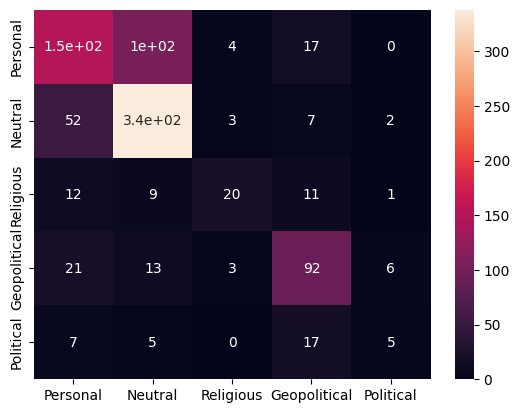

In [470]:
count_nb_classifier = MultinomialNB(alpha=0.4)
count_nb_classifier.fit(count_train, y_train)

valid_score = count_nb_classifier.score(count_val, y_val)

predictions = count_nb_classifier.predict(count_test)
f1_micro = metrics.f1_score(y_test, predictions, average='micro')
f1_macro = metrics.f1_score(y_test, predictions, average='macro')
f1_weighted = metrics.f1_score(y_test, predictions, average='weighted')
cf_matrix = metrics.confusion_matrix(y_test, predictions, labels=y_test.unique())

sns.heatmap(cf_matrix, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique())
print("Validation score: %0.2f" % valid_score)
# print("F1 score (micro): %0.2f \nF1 score (macro): %0.2f \nF1 score (weighted): %0.2f" 
#       % (f1_micro, f1_macro, f1_weighted))

report = metrics.classification_report(y_test, predictions)
print(report)

### Multinomial Naïve Bayes using TFIDF Vectorizer

Here I also adjusted the alpha parameter and found that this model needed a much lower alpha and works best at around 0.08.

Validation score: 0.70
              precision    recall  f1-score   support

Geopolitical       0.65      0.63      0.64       135
     Neutral       0.71      0.85      0.77       402
    Personal       0.57      0.53      0.55       276
   Political       0.44      0.12      0.19        34
   Religious       0.82      0.34      0.48        53

    accuracy                           0.66       900
   macro avg       0.64      0.49      0.53       900
weighted avg       0.65      0.66      0.64       900



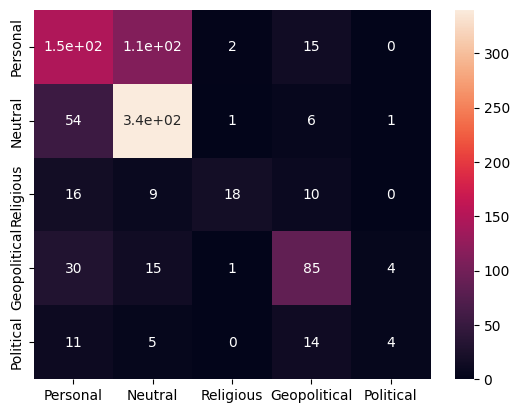

In [471]:
tfidf_nb_classifier = MultinomialNB(alpha=0.08)
tfidf_nb_classifier.fit(tfidf_train, y_train)

valid_score = tfidf_nb_classifier.score(tfidf_val, y_val)

predictions = tfidf_nb_classifier.predict(tfidf_test)
accuracy = metrics.accuracy_score(y_test, predictions)
f1_micro = metrics.f1_score(y_test, predictions, average='micro')
f1_macro = metrics.f1_score(y_test, predictions, average='macro')
f1_weighted = metrics.f1_score(y_test, predictions, average='weighted')
cf_matrix = metrics.confusion_matrix(y_test, predictions, labels=y_test.unique())

sns.heatmap(cf_matrix, annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique())
print("Validation score: %0.2f" % valid_score)
# print("Accuracy score: %.2f \nF1 score (micro): %0.2f \nF1 score (macro): %0.2f \nF1 score (weighted): %0.2f" 
#       % (accuracy, f1_micro, f1_macro, f1_weighted))

multi_cmat = metrics.multilabel_confusion_matrix(y_test, predictions)
report = metrics.classification_report(y_test, predictions)
print(report)


### Getting the Most Informative Features

In [472]:
count_feature_names = count_vectorizer.get_feature_names_out()
count_feature_importance = count_nb_classifier.feature_log_prob_

for class_idx, class_label in enumerate(count_nb_classifier.classes_):
    class_importance_scores = count_feature_importance[class_idx]
    top_feature_idx = np.argsort(class_importance_scores)[-3:]
    top_feature_names = [count_feature_names[idx] for idx in top_feature_idx]
    print(class_label, top_feature_names)

Geopolitical ['বলদশ', 'নয়', 'কর']
Neutral ['যখন', 'আমর', 'কর']
Personal ['তর', 'আম', 'কর']
Political ['শখ', 'এই', 'কর']
Religious ['হয়', 'ইসলম', 'কর']


In [473]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_importance = tfidf_nb_classifier.feature_log_prob_

for class_idx, class_label in enumerate(tfidf_nb_classifier.classes_):
    class_importance_scores = tfidf_feature_importance[class_idx]
    top_feature_idx = np.argsort(class_importance_scores)[-3:]
    top_feature_names = [tfidf_feature_names[idx] for idx in top_feature_idx]
    print(class_label, top_feature_names)

Geopolitical ['কর', 'ভরত', 'বলদশ']
Neutral ['আম', 'যখন', 'আমর']
Personal ['আম', 'তর', 'কর']
Political ['ছতরলগ', 'আওয়মলগ', 'শখ']
Religious ['ধরম', 'কর', 'ইসলম']
